## Projeto de Redes Sociais

In [102]:
import freeman as fm
import pandas as pd
import seaborn as sns
from unidecode import unidecode
import math
import random
import statsmodels.api as sm
import networkx as nx
import pylab


In [3]:
athletes = pd.read_csv('data/crossfit/2019_opens_athletes.csv')

C:\Users\lchen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
# scores = pd.read_csv('data/crossfit/2019_opens_scores.csv')

In [5]:
athletes = athletes.dropna(subset=['affiliateid', 'affiliatename', 'overallrank'])
men = athletes[athletes['divisionid'] == 1]
gyms = {}
for _, row in men.iterrows():
    if (row['affiliateid'] in gyms.keys()):
        if (gyms[row['affiliateid']][0] != row['affiliatename']):
            print('Duplicate', gyms[row['affiliateid']], row['affiliatename'])
    gyms[row['affiliateid']] = [row['affiliatename']]

In [6]:
for key, value in gyms.items():
    gyms[key].append(men[men['affiliateid'] == key]['overallscore'].mean())

In [7]:

gyms = {k: v for k, v in sorted(gyms.items(), key=lambda item: item[1][1])}

gyms_list = list(gyms.values())
# gyms_list = [0, 1, 2, 3]
if (len(gyms_list) % 2 == 0):
    median = (gyms_list[int(len(gyms_list) / 2)][1] + gyms_list[int(len(gyms_list) / 2) - 1][1]) / 2
else:
    median = gyms_list[math.floor(len(gyms_list) / 2)][1]
print(median)

406265.5


In [106]:
gyms_list = list(gyms.items())
print(len(gyms_list))

for _ in range(int(len(gyms_list) / 1.1)):
    rand_int = random.randint(0, len(gyms_list) - 1)
    gyms_list.pop(rand_int)
print(len(gyms_list))


11335
1031


In [107]:
filename = 'data/gyms.gml'
with open(filename, 'w') as f:
    tmp = 'graph [\n  directed 0\n'

    for affiliateid, value in gyms_list:
        tmp += '  node [\n    id ' + str(affiliateid) + '\n    affiliate_name "' + unidecode(value[0]) + '"\n  ]\n'

    f.write(tmp)
    i = 0
    for affiliateid, value in gyms_list:
        percentage = round(i/len(gyms.items())*100, 2)
        if (percentage % 1 == 0):
            print('Progress: {}%'.format(percentage, ), end = '\r')
        for affiliate2id, value2 in gyms_list[gyms_list.index((affiliateid, value)) + 1:]:
#             if ((affiliateid != affiliate2id) and (((value[1] + value2[1]) / 2) > median) ):
            if ((affiliateid != affiliate2id) and ((value[1] > median) and (value2[1] > median))):
                f.write('  edge [\n    source ' + str(affiliateid) +'\n    target ' + str(affiliate2id) +'\n  ]\n')
        i += 1

    f.write(']')
    print('Progress: {}%'.format(100.0))
    print('Done')



Progress: 100.0%
Done


In [108]:
g = fm.load('data/gyms.gml')

In [109]:
g.set_all_nodes(size=10, labpos='hover')

# Deixar as arestas semi-transparentes para
# a visualização ficar um pouco mais leve.
g.set_all_edges(color=(0, 0, 0, 0.25))

# Usar um algoritmo especial para posicionar
# os nós de acordo com grupos.
g.move('kamada_kawai')

g.draw()

KeyboardInterrupt: 

In [110]:
gym_scores = [x[1][1] for x in gyms_list]
gyms_closeness = []
for gym in gyms_list:
    for n in g.nodes:
        if n == gym[0]:
            gyms_closeness.append(nx.closeness_centrality(g, n))

<ipython-input-111-a3c449b94a20>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



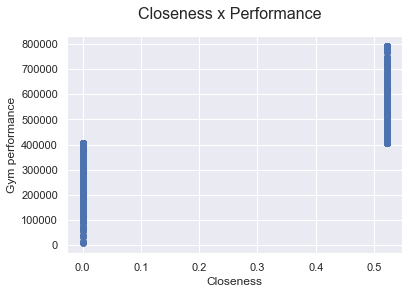

In [111]:

ax = pylab.subplot(111)
ax.scatter(gyms_closeness, gym_scores)
pylab.xlabel('Closeness')
pylab.ylabel('Gym performance')
pylab.suptitle('Closeness x Performance', fontsize=16)
ax.figure.show()

In [112]:
model = sm.OLS(gym_scores, gyms_closeness)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              2490.
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                   3.88e-277
Time:                        21:22:37   Log-Likelihood:                         -14211.
No. Observations:                1031   AIC:                                  2.842e+04
Df Residuals:                    1030   BIC:                                  2.843e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.647e+05   1.93e+04     49.904      0.000    9.27e+05       1e+06
==============================================================================
Omnibus:                     5240.800   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.495
Skew:                           0.028   Prob(JB):                     1.86e-26
Kurtosis:                       1.340   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""